# Ant Colony Optimisation

### A whirlwind tour of bio-inspired computing algorithms

#### Quentin Caudron

The [ant colony optimisation](https://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms) (ACO) algorithm is a subset of [swarm intelligence](https://en.wikipedia.org/wiki/Swarm_intelligence) methods. It relies on the [emergence](https://en.wikipedia.org/wiki/Emergence) of complex behaviours from the interactions of simple agents. 

Let's say we want to find a shortest path through a graph with constraints. We let some "ants" loose on the graph and allow them to perform a random walk. Should they find what they are looking for, they return home, leaving behind a trail of "pheromones" as they go; pheromones evaporate over time. Ants still seeking their goal are more likely to follow edges with pheromones. Due to the evaporation of pheromones, shortest paths to their goal are more strongly reinforced because the pheromones have less time to evaporate, and so the ants collectively but completely independently reinforce more optimal solutions, hopefully converging on the global optimum.

Ant colony optimistations can be run continuously if the underlying graph changes over time, allowing the algorithm to dynamically adapt to changes in the space. The ACO has been shown to provide near-optimal solutions to the travelling salesman problem, and has applications in routing, scheduling, and even obscure applications in image processing.

<img src="images/aco.png" width="700px" />

### The inspiration

In their search for food, certain species of ant may begin by randomly walking around. When food is found, the ant will return to the nest, leaving behind it a trail of pheromones that other ants can follow. Short trails to food are eventually reinforced by positive feedback, allowing large numbers of ants to rapidly exploit the food resource; should an ant arrive at the end of a pheromone trail and find no food, it will return to randomly wandering, and the pheromone trail, no longer reinforced by ants returning home, will evaporate.

In [1]:
import os
import shutil
import subprocess
from time import sleep
import numpy as np
from scipy.sparse import dok_matrix
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from tqdm import tnrange
from numba import jit

In [2]:
# Pull London Underground data
# https://commons.wikimedia.org/wiki/London_Underground_geographic_maps/CSV
stations = pd.read_csv("data/london_tube_latlong.csv")
lines = pd.read_csv("data/london_tube_lines.csv")

# Construct adjacency matrix
A = np.zeros((stations.id.max()+1, stations.id.max()+1))
for station1, station2 in zip(lines.station1, lines.station2):
    A[station1, station2] += 1
A += A.T

# Generate positions by latitude and longitude
pos = {id: np.array([lon, lat]) for id, lat, lon in zip(stations.id, stations.latitude, stations.longitude)}
for i in range(stations.id.max()+1):
    if i not in pos:
        pos[i] = np.array([0, 0])
        
# Create a networkx graph
G = nx.Graph(A)

In [3]:
class Ant(object):
    
    def __init__(self, start, target):
        """Set the ant's initial position."""
        self.position = start
        self.home = start
        self.target = target
        self.is_returning = False
        
    def move(self, possible_moves, pheromones, paths_home):
        """Move the ant to an adjacent node."""
        
        if not self.is_returning:
            
            # With 20% chance, don't move at all
            if np.random.rand() < 0.2:
                return
    
            # Calculate probabilities for each edge
            rates = [1 + pheromones[self.position, possible_move] for possible_move in possible_moves[self.position]]
            probabilities = rates / np.sum(rates)

            # Select a new node
            move = np.random.choice(possible_moves[self.position], p=probabilities)
            self.position = move

            # Check whether we have found food
            if self.position == self.target:
                self.is_returning = True
                
        else:
            # Go home, leaving pheromones as you go
            pheromones[self.position, paths_home[self.position]] += 10
            self.position = paths_home[self.position]
            
            if self.position == self.home:
                self.is_returning = False


#@jit
def call_move(args):
    # Para-para-parallel
    ant, possible_moves, pheromones, paths_home = args
    ant.move(possible_moves, pheromones, paths_home)
    return True

def initialise_world(A, N_ants, start, end, evaporation_rate=0.1):
    """Set up the world, per the adjacency matrix."""
    
    # Initialise pheromones as per the adjacency matrix
    pheromones = np.zeros_like(A)
    
    # Create ants
    ants = [Ant(start, end) for _ in range(N_ants)]
    
    # Define the legal moves through the graph
    possible_moves = [np.where(A[:, i])[0] for i in range(A.shape[0])]
    
    # Remember the way home
    paths_home = {}
    for node in range(A.shape[0]):
        try:
            paths_home[node] = nx.dijkstra_path(nx.Graph(A), node, start)[1]
        except:
            paths_home[node] = []
    
    return ants, pheromones, possible_moves, paths_home


#@jit
def advance_world(ants, pheromones, possible_moves, paths_home, evaporation_rate):
    """Step forward one timestep, updating ant positions and pheromones."""
    
    # Move all ants
    for ant in ants:
        ant.move(possible_moves, pheromones, paths_home)

    # Update the edges in the graph for pheromone levels
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if A[i, j]:
                G[i][j]["pheromones"] = pheromones[i, j] / pheromones.max()

    # Evaporate pheromones exponentially
    pheromones *= (1 - evaporation_rate)
        
    return ants, pheromones


def draw_london(start=None, end=None, ants=None, pheromones=None):
    
    plt.figure(figsize=(14, 10))
    sizes = np.ones(G.number_of_nodes()) * 100

    if ants is not None:
        node_colours = np.array([[ant.position for ant in ants].count(i) for i in range(A.shape[0])]).astype(float)
        node_colours /= len(ants)
    else:
        node_colours = [1] * G.number_of_nodes()
        
    if pheromones is not None:
        edge_colours = np.array([pheromones[i, j] + pheromones[j, i] for i, j in G.edges()])
        edge_colours /= edge_colours.max()
    else:
        edge_colours = "k"
        
    if start:
        sizes[start] = 500
        
    if end:
        sizes[end] = 1000

    nx.draw_networkx_nodes(G, pos=pos, node_color=node_colours, node_size=sizes, cmap="plasma", animated=True)
    nx.draw_networkx_edges(G, pos=pos, width=3, edge_color=edge_colours, cmap="plasma", animated=True)

    plt.ylim(51.38, 51.72)
    plt.xlim(-0.65, 0.3)
    
    plt.tight_layout()
    

def generate_animation(A, N_ants, rounds, start, end, evaporation_rate=0.005):
    
    random_filename = "images/animations_{}/".format(np.random.randint(1, 100000000))
    os.mkdir(random_filename)
    
    # Initialise world
    ants, pheromones, possible_moves, paths_home = initialise_world(A, N_ants, start, end, evaporation_rate)
    
    draw_london(start, end, ants=ants)
    plt.savefig("{}/{:05d}.jpg".format(random_filename, 0))
    
    # Step through timesteps
    for i in tnrange(rounds):
        ants, pheromones = advance_world(ants, pheromones, possible_moves, paths_home, evaporation_rate)
        draw_london(start, end, ants=ants, pheromones=np.exp(pheromones))
        plt.savefig("{}/{:05d}.jpg".format(random_filename, i+1))
        plt.close()

    # Generate movie
    if os.path.exists("images/out.mp4"):
        os.remove("images/out.mp4")
    subprocess.call("ffmpeg -pattern_type glob -i '{}*.jpg' -c:v libx264 -vf fps=25 images/out.mp4".format(random_filename), shell=True)
    sleep(1)
    shutil.rmtree(random_filename[:-1])
    
    return ants, pheromones
    
    
def run_animation():
    subprocess.call("open images/out.mp4", shell=True)

/Users/qcaudron/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:82: RuntimeWarning: invalid value encountered in double_scalars


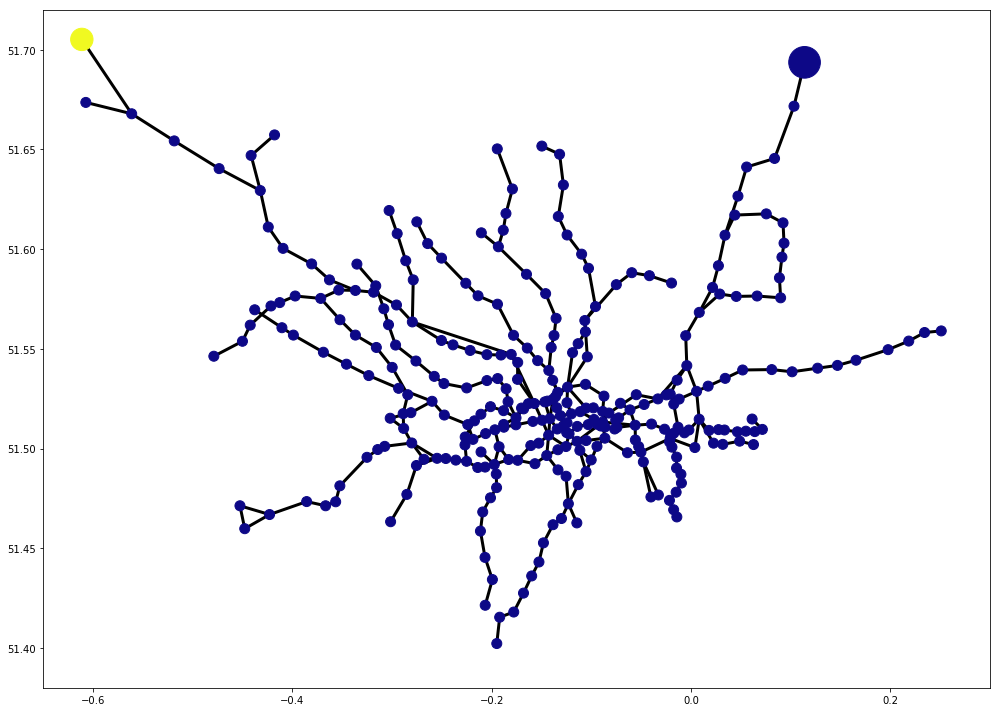

In [4]:
ants, pheromones = generate_animation(A, 300, 1000, 50, 88)

In [ ]:
run_animation()

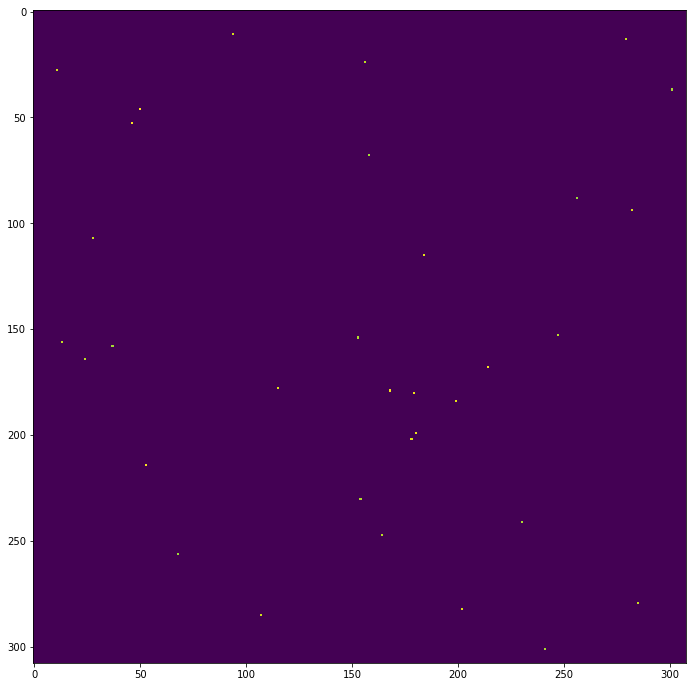

In [6]:
plt.figure(figsize=(12, 12))
plt.imshow((pheromones))